# Bollinger Band Strategy
This strategy calculates the moving average for a stock of our choice and finds Bollinger Band cutoffs 2 standard deviations above and below the return price. These cutoffs tell us when to buy, sell, and hold depending on which direction the bands are crossed from. The idea behind this strategy is that the closer the prices move to the upper band, the more overbought the market, and the closer the prices move to the lower band, the more oversold the market.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

### Downloading the Data
We are using Keurig Dr. Pepper for this strategy, and only looking at data for just over a year. We get the adjusted close from yfinance and calculate the return.

In [2]:
df = yf.download('KDP', start = '2023-1-1', end = None, auto_adjust = True)
df.drop(['Open','High','Low', 'Volume'], axis=1, inplace=True)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2023-01-03,34.457832
2023-01-04,34.738926
2023-01-05,34.397774
2023-01-06,35.343250
2023-01-09,35.119064


In [3]:
# Buy and hold (benchmark) returns
df['return'] = np.log(df['Close']).diff()
df.head()

,Close,return
Date,,
2023-01-03,34.457832,NaN
2023-01-04,34.738926,0.008125
2023-01-05,34.397774,-0.009869
2023-01-06,35.343250,0.027116
2023-01-09,35.119064,-0.006363


### Creating the Bands
Bollinger bands are 2 standard deviations above and below the last 20 day average closing price. The first cell here creates the bands and provides a visualization for our thresholds. The following cell creates buy signals when the close rises above the lower band and a sell signal when the close falls below the upper band, and then puts those returns in a new column in our dataframe.

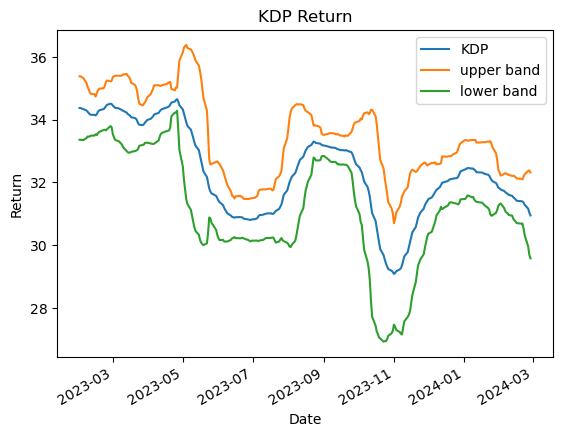

In [13]:
# creating bollinger bands 2 standard deviations above and below moving averages
df['20-day'] = df['Close'].rolling(window=20).mean()
df['std'] = df['Close'].rolling(window=20).std()
df['upper_band'] = df['20-day'] + (2 * df['std'])
df['lower_band'] = df['20-day'] - (2 * df['std'])

df['20-day'].plot(label = "KDP")
df['upper_band'].plot(label = 'upper band')
df['lower_band'].plot(label = 'lower band')
plt.title(f'KDP Return')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()

In [5]:
# Buy condition
df['signal'] = np.where((df['Close'] < df['lower_band']) & (df['Close'].shift(1) >= df['lower_band']),1,0)

# Sell condition
df['signal'] = np.where( (df['Close'] > df['upper_band']) & (df['Close'].shift(1) <= df['upper_band']),-1,df['signal'])

# creating long and short positions
df['position'] = df['signal'].replace(to_replace=0, method='ffill')
df['position'] = df['position'].shift(1)

df['strategy_returns'] = df['return'] * (df['position'])

df.tail()

,Close,return,20-day,std,upper_band,lower_band,signal,position,strategy_returns
Date,,,,,,,,,
2024-02-22,30.370001,-0.039702,31.3550,0.417139,32.189278,30.520722,1,1.0,-0.039702
2024-02-23,30.190001,-0.005945,31.2850,0.487210,32.259419,30.310581,1,1.0,-0.005945
2024-02-26,29.500000,-0.023120,31.1610,0.602878,32.366756,29.955244,1,1.0,-0.023120
2024-02-27,29.500000,0.000000,31.0355,0.673908,32.383316,29.687684,0,1.0,0.000000
2024-02-28,30.030001,0.017807,30.9470,0.684367,32.315735,29.578265,0,1.0,0.017807


### Performance

Below is a numerical comparison and graphical visualization of our strategy versus a "buy and hold" benchmark, as well as the Sharpe ratio of each. We're using a risk-free rate of 0%. Our strategy outperforms the benchmark.

In [6]:
benchmark_return = np.exp(df['return']).cumprod()[-1] -1
system_return = np.exp(df['strategy_returns']).cumprod()[-1] -1
benchmark_sharpe = (df['return'].mean()/np.std(df['return'])) * np.sqrt(252)
system_sharpe = (df['strategy_returns'].mean()/np.std(df['strategy_returns'])) * np.sqrt(252)

print('Benchmark Sharpe Ratio: ', benchmark_sharpe.round(2),
      '\nBenchmark Return: ', benchmark_return.round(2),
      '\nSystem Sharpe Ratio: ', system_sharpe.round(2),
      '\nSystem Return: ', system_return.round(2))

Benchmark Sharpe Ratio:  -0.66 
Benchmark Return:  -0.13 
System Sharpe Ratio:  0.65 
System Return:  0.14


<Axes: xlabel='Date'>

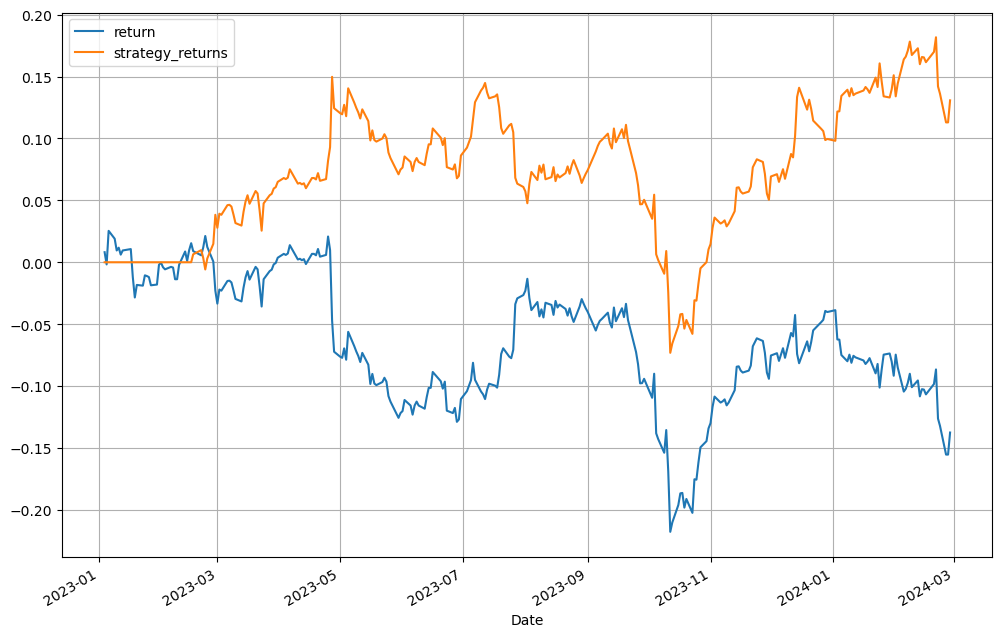

In [7]:
df[['return', 'strategy_returns']] = df[['return', 'strategy_returns']].cumsum()
df[['return', 'strategy_returns']].plot(grid=True, figsize=(12, 8))

#### Motivation
Standard deviation represents the average fluctuation in closing price, and we wanted to experiment with comparing that deviation to trends in closing price. Bollinger bands are a well-documented trading strategy with lots of support, so we figured implementing it ourselves would be safe and effective.

#### Analysis
Our strategy had a cumulative return of ~12% versus the -14% of the buy and hold benchmark. The Sharpe ratio also improved from unacceptable (-.75) to decent (.56). Looking at the plot, our strategy almost mirrored the benchmark albeit in a positive direction. The Bollinger bands we created accurately signalled when the market was overbought or oversold. The main issue with this strategy is that it improves upon an existing stock, but it is still simple; it relies too much on the original stock's movement. We can see the data around October 2023 that shows we still have negative returns in that period. This strategy could likely be improved with another threshold representing maximum change in moving average, giving us a way to "pause" or exit all positions if the stock starts decreasing too rapidly.

#### References
https://www.investopedia.com/terms/b/bollingerbands.asp